In [1]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"

In [3]:
def kth_diag_indices(a, k):
    # negative numbers go below the diagonal, 0 is the main diagonal and positive nums go above
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
# Find index of the closest value
def find_nearest(arr, target):
    idx = np.abs(arr - target).argmin()
    return arr[idx], idx

def separate_band(eigen_array, energy_array):
    # since linalg spits out eigenvalues is some weird order se
    # organize them in the proper band corresponding to the qubit states
    band_list = []
    index_list = []
    for target_ in energy_array:
        closest, index_c = find_nearest(eigen_array, target_)
        band_list.append(closest)
        index_list.append(index_c)
    
    return np.asarray(band_list), index_list


# Exact Diagonalziation

**It may be better to build the hamiltonian myself and the diagonalize it**

In [4]:
L_qpc= 21
L = L_qpc + 2
t = 0.3 # dd hopping
Omega = 0.5
J_prime = 1
bond_index = int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  

# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]
bond_index

10

In [5]:
"""# create the hamiltonian start with qpc
H_QC = get_qpc_H(c_list, L ,L_qpc,J)

# double dot H
Hdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])

# interaction H
Hint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[bond_index].dag()*c_list[bond_index+1] +
                                          c_list[bond_index+1].dag()*c_list[bond_index] )

H = H_QC + Hdot  + Hint

energies,e_states , = H.eigenstates()
print(np.shape(energies), np.shape(e_states))"""

'# create the hamiltonian start with qpc\nH_QC = get_qpc_H(c_list, L ,L_qpc,J)\n\n# double dot H\nHdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])\n\n# interaction H\nHint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[bond_index].dag()*c_list[bond_index+1] +\n                                          c_list[bond_index+1].dag()*c_list[bond_index] )\n\nH = H_QC + Hdot  + Hint\n\nenergies,e_states , = H.eigenstates()\nprint(np.shape(energies), np.shape(e_states))'

Bond at:  20


<Axes: >

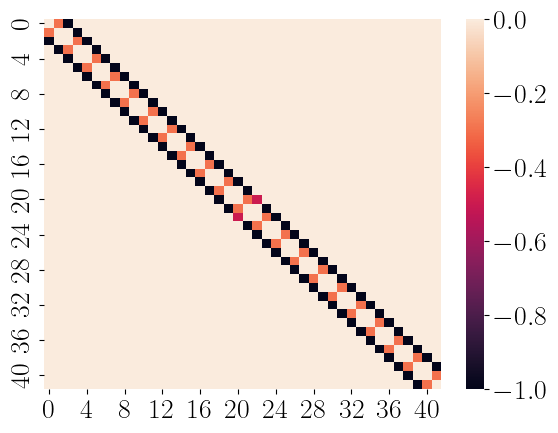

In [6]:
H_matrix = np.zeros((2*L_qpc,2*L_qpc))
# fill in the dd hopping only in odd diagonals
d_indices= kth_diag_indices(H_matrix,1)
H_matrix[d_indices] = -t

# fill in the QPC hopping
d_indices= kth_diag_indices(H_matrix,2)
H_matrix[d_indices] = -J[0]

# when qpc and qubit hop a the same time there is no contribution
d_indices= kth_diag_indices(H_matrix,1)
odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
H_matrix[odd_inds] = 0

"""d_indices= kth_diag_indices(H_matrix,3)
even_inds = (d_indices[0][0::2], d_indices[1][0::2])
H_matrix[even_inds] = 0"""

# Fill in the interaction at the bond
H_matrix[2*bond_index,2*(bond_index+1)] = H_matrix[2*bond_index,2*(bond_index+1)]+ Omega

# Now the elemets below the diagonal
for i in range(0,2*L_qpc):
    for j in range(i + 1, 2*L_qpc):
        H_matrix[j, i] = H_matrix[i, j]

print("Bond at: ", 2*bond_index)
sns.heatmap(H_matrix)


In [7]:
# Calculate the energies and eigenvectors
energies, eigen_vecs = np.linalg.eig(H_matrix)

print(energies)


[ 2.25392348  2.21931287  2.08801486  1.98404242 -2.25392348 -2.21931287
  1.79115362  1.6504323   1.6109578   1.61895121  1.48218165  1.38896888
  1.34926299  1.1817433   1.12118153  1.01199949 -2.08801486 -1.98404242
  0.85181481  0.75166039  0.58282607  0.53201576  0.30072812  0.24825108
  0.01456501 -0.01456501 -0.24825108 -0.30072812 -1.79115362 -0.53201576
 -0.58282607 -1.6504323  -1.6109578  -1.61895121 -1.48218165 -1.38896888
 -1.34926299 -0.75166039 -0.85181481 -1.1817433  -1.12118153 -1.01199949]


Here we expect two bands, however we have to be carefull because **linalg spits the eigenvectors and states all mixed up instead of in neat bands**. Since the compostie hamiltonian is of size 2*L the k-momenta of the QPC appear doubled, but this is just because we have two bands.

In [8]:
# Normalization of the zeroth order eigenstates
Norm = np.sqrt(2/(L_qpc+1))

# calculate the decoupled system analytic eigenenergies (zeroth order correction)
k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)
em0 = -2*J[0]*np.cos(k_single_band) - t 
ep0 = -2*J[0]*np.cos(k_single_band) + t 

# separate into bands
energies_m, states_m = separate_band(energies,em0)
energies_p, states_p = separate_band(energies,ep0)

# Zeroth Order

Text(0, 0.5, '$E$')

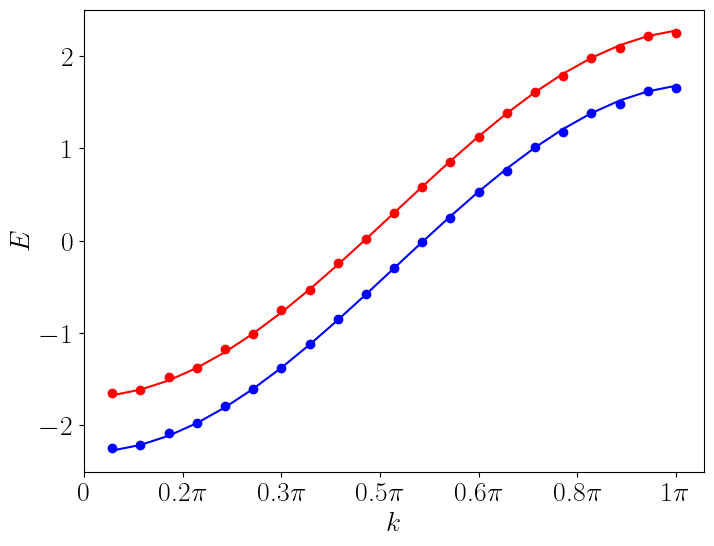

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

# zeroth order
plt.plot(k_single_band, em0, c= "blue")
plt.plot(k_single_band, ep0, c= "red")

# diagonalized
plt.scatter(k_single_band,energies_m, c= "blue")
plt.scatter(k_single_band,energies_p, c= "red")


# write x axis in units of pi
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
plt.xlabel(r"$k$")
plt.ylabel(r"$E$")

## First Order Benchmark

here, both bands have the same correction. Notice how the perturbation is zero at some momenta namely **the perturbation is very small around $\pi/2$** and larger at the edges of the brillouin zone.

Text(0, 0.5, 'First Order Correction')

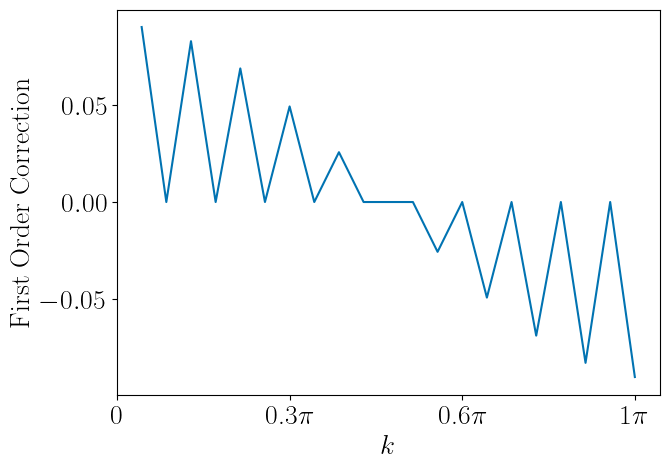

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# First order corrections
e1 = (Norm**2)*np.sin(bond_index*k_single_band)*np.sin(bond_index*k_single_band+k_single_band)

plt.plot(k_single_band, e1)


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

plt.xlabel(r"$k$")
plt.ylabel(r"First Order Correction")

Text(0, 0.5, '$E$')

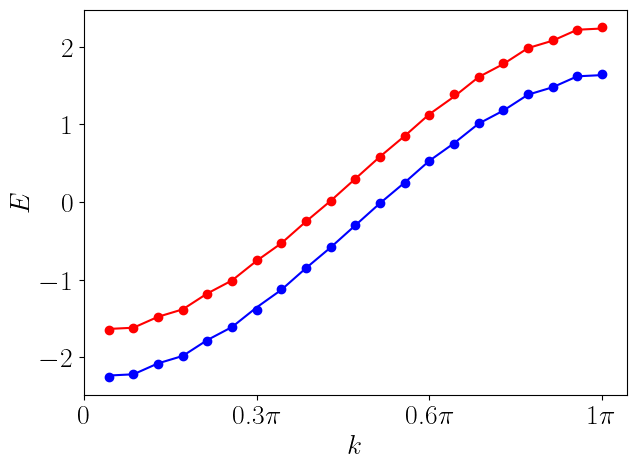

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7,5))


# first order corrections
Em = em0 + Omega*e1
Ep = ep0 + Omega*e1

plt.scatter(k_single_band,energies_m, c= "blue")
plt.scatter(k_single_band,energies_p, c= "red")

plt.plot(k_single_band, Em, c= "blue")
plt.plot(k_single_band, Ep, c= "red")


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

plt.xlabel(r"$k$")
plt.ylabel(r"$E$")

Text(0, 0.5, '$Errors$')

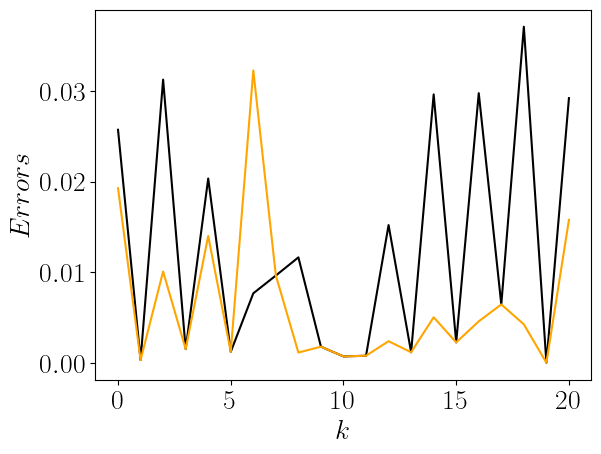

In [12]:
# plot the errors of the first correction vs zeroth order

Err0m = np.abs(energies_m - em0)
Err1m = np.abs(energies_m - Em)

plt.plot(Err0m, c="black")
plt.plot(Err1m, c="orange")

plt.xlabel(r"$k$")
plt.ylabel(r"$Errors$")

We can also compare the eigenstates prediction

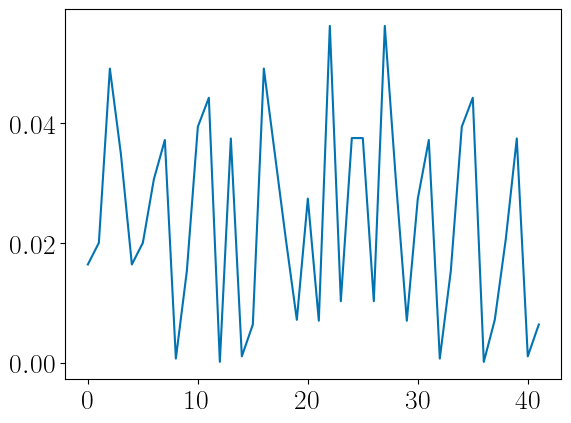

In [13]:
# separate into bands
energies_m, states_m = separate_band(energies,em0)

# lowest energy one 
estate = eigen_vecs[states_m[0]]

plt.plot(estate*estate)

# Second Order

Due to the normalization factor these corrections are super small nad the longer the chain the smaller they become

In [14]:
def xhi(K,P, B):
    return np.sin(B*P+P)*np.sin(B*K) + np.sin(B*K+K)*np.sin(B*P)

e2 = []

for k in k_single_band:
    # remove k so te sums don't blow up
    p_range = new_list = np.asarray([x for x in k_single_band if x != k])

    T1 = (Norm**2)**2*(1/4)*np.sum( (xhi(k, p_range, bond_index)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))) )
    T2 = (Norm**2)**2*(1/4)*(1/(2*t))*xhi(k,k,bond_index)**2
    T3 = (Norm**2)**2*(1/4)*np.sum( (xhi(k, p_range, bond_index)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))+2*t) )

    e2.append(T1 + T2 + T3) 
    
e2 = np.asarray(e2)

Text(0, 0.5, '$E$')

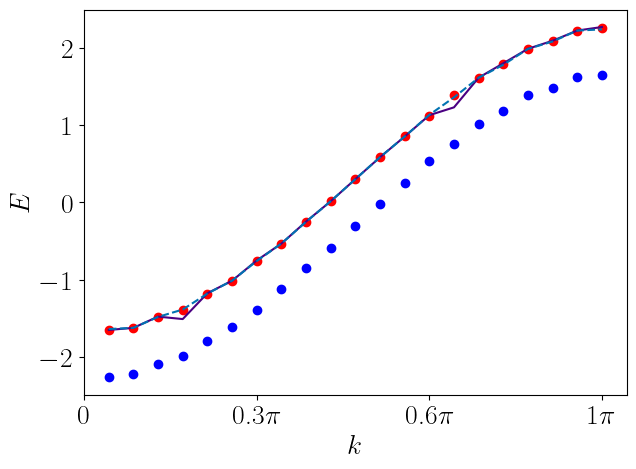

In [15]:
fig, ax = plt.subplots(1,1, figsize=(7,5))


Ep1 = ep0 + Omega*e1
Ep2 = ep0 + Omega*e1 + (Omega**2)*e2
#Em2 = em0 + Omega*e1 + (Omega**2)*e2


plt.scatter(k_single_band,energies_m, c= "blue")
plt.scatter(k_single_band,energies_p, c= "red")

plt.plot(k_single_band, Ep2, c="indigo")
plt.plot(k_single_band, Ep1, linestyle="dashed")


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi) 
                                                             if val !=0 else '0'))

plt.xlabel(r"$k$")
plt.ylabel(r"$E$")